# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 32D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$ (Using the method of characterization).
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 32  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1000 # Iterations for initial training phase
iterations_exp_long = 30000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.1.2===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

# def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
#     """
#     Computes S(y, t=1) for J(x)=||x||_1.
#     S(y, 1) = ||prox_t(y)||_1 + n*t/2*||y - prox_t(y)||_2^2 where prox_t(y) is prox of t*J at y.
#     For J(x)=||x||_1 and t=1, this simplifies.
#     The value S(y,t) is the Moreau envelope of tJ at y.
#     S(y, 1) = min_x { 0.5*||x-y||^2 + ||x||_1 }
#     The solution is x* = prox_1(y) (soft-thresholding)
#     S(y,1) = 0.5*||prox_1(y) - y||^2 + ||prox_1(y)||_1
#     """
#     t_moreau = 1.0
#     prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    
#     # Using the definition of the Moreau envelope value
#     val = 0.5 * euclid_norm_sq(y_points - prox_y) + np.sum(np.abs(prox_y), axis=1)
#     return val # N-dimensional array

# Analytic solution
# def hjsol_true_quadratic_l1(y_points, t=.3):
#     """
#     Computes the true analytical solution for S(x, t) for J(x)=||x||_1.
#     This is the closed-form solution to the Moreau envelope problem.
#     S(x, t) = Σ_{i:|x_i|≥t} (|x_i| - t/2) + Σ_{i:|x_i|<t} (x_i^2 / 2t)
#     """
#     # Create a boolean mask for the two conditions
#     mask_geq = np.abs(y_points) >= t
#     mask_lt = np.abs(y_points) < t
    
#     # Calculate the first term for elements where |x_i| >= t
#     term1 = np.sum((np.abs(y_points) - t/2) * mask_geq, axis=1)
    
#     # Calculate the second term for elements where |x_i| < t
#     term2 = np.sum((y_points**2 / (2*t)) * mask_lt, axis=1)
    
#     # The total value is the sum of the two terms
#     val = term1 + term2
#     return val

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array


# def evaluate_learned_J_HJ_approx(x_eval_points_np, model):
#     """
#     Evaluates the learned prior J_est(x) using the method of characteristics approximation.
#     J(x) ≈ <x, ∇ψ(x,1)> - 0.5*||x||² - ψ(∇ψ(x,1),1)
    
#     Args:
#         x_eval_points_np (np.ndarray): N x dim array of points to estimate J(x) at.
#         model: The trained LPN model object (e.g., a torch.nn.Module) that learns psi(x, 1).
    
#     Returns:
#         np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
#     """
#     # Move model to eval mode
#     model.eval()
    
#     x_tensor = torch.from_numpy(x_eval_points_np).float().to(device)
#     x_tensor.requires_grad_(True)
    
#     # ∇ψ(x,1) = model(x)
#     grad_psi_x_tensor = model(x_tensor)
    
#     # <x, ∇ψ(x,1)>
#     term1_tensor = torch.sum(x_tensor * grad_psi_x_tensor, dim=1, keepdim=True)
    
#     # 0.5*||x||²
#     term2_tensor = 0.5 * torch.sum(x_tensor**2, dim=1, keepdim=True)
    
#     # ψ(∇ψ(x,1),1)
#     term3_tensor = model.scalar(grad_psi_x_tensor)
    
#     # J(x) approximation
#     J_approx_tensor = term1_tensor - term2_tensor - term3_tensor
    
#     return J_approx_tensor.detach().cpu().numpy().flatten()

# def evaluate_learned_J_HJ_approx(x_eval_points_np, model, t_val=1.0):
#     """
#     Evaluates the learned prior J_est(x) using the method of characteristics approximation.
#     This function follows the step-by-step derivation for H(p) = 0.5 * ||p||^2.
    
#     Derivation steps:
#     1. From characteristics: J(x) ≈ S(x - t*∇S(x,t), t) - (t/2)*||∇S(x,t)||^2
#        (using the approximation p₀ = -∇S(x,t), which appears to be a typo in the source
#         and should likely be p₀ = ∇S(x,t) for the forward problem, but we follow the text's
#         subsequent algebraic steps which are consistent regardless of this choice).
#     2. Using ψ(x,t) = 0.5*||x||² - t*S(x,t), we can show:
#        x - t*∇S(x,t) = ∇ψ(x,t)
#     3. Substituting into the J(x) approximation yields the intermediate form:
#        J(x) ≈ S(∇ψ(x,t), t) - (1/2t)*||x - ∇ψ(x,t)||^2
#     4. This function implements step 3 directly, which is computationally equivalent
#        to the fully simplified final form.

#     Args:
#         x_eval_points_np (np.ndarray): N x dim array of points to estimate J(x) at.
#         model: The trained LPN model object (e.g., a torch.nn.Module) that learns psi(x, t).
#         t_val (float): Time parameter, set to 1.0 as per the derivation.
    
#     Returns:
#         np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
#     """
#     # Set model to evaluation mode
#     model.eval()
    
#     x_tensor = torch.from_numpy(x_eval_points_np).float().to(device)
#     x_tensor.requires_grad_(True)
    
#     # --- Step 1: Compute terms based on ψ ---
#     # nabla_psi_x_tensor = ∇ψ(x,t)
#     nabla_psi_x_tensor = model(x_tensor)
    
#     # --- Step 2: Compute S(∇ψ(x,t), t) using the relationship S(y,t) = (1/2t)*||y||² - (1/t)*ψ(y,t) ---
#     def S_from_psi(y_tensor, t):
#         psi_y = model.scalar(y_tensor)
#         norm_sq_y = torch.sum(y_tensor**2, dim=1, keepdim=True)
#         S_y_t = (0.5 / t) * norm_sq_y - (1.0 / t) * psi_y
#         return S_y_t
        
#     S_of_nabla_psi_tensor = S_from_psi(nabla_psi_x_tensor, t_val)
    
#     # --- Step 3: Compute the second term (1/2t)*||x - ∇ψ(x,t)||^2 ---
#     x_minus_nabla_psi_tensor = x_tensor - nabla_psi_x_tensor
#     norm_sq_diff_tensor = torch.sum(x_minus_nabla_psi_tensor**2, dim=1, keepdim=True)
#     second_term_tensor = (0.5 / t_val) * norm_sq_diff_tensor
    
#     # --- Step 4: Combine terms to get the J(x) approximation ---
#     J_approx_tensor = S_of_nabla_psi_tensor - second_term_tensor
    
#     return J_approx_tensor.detach().cpu().numpy().flatten()

def evaluate_learned_J_HJ_approx(x_eval_points_np, model, t_val=0.2):
    """
    Evaluates the learned prior J_est(x) using the LPN and HJ approximation.
    J(x) ≈ S(x + t*grad_S(x,t), t) - (t/2)*||grad_S(x,t)||^2
    where S(x,t) = (1/2t)||x||^2 - (1/t)psi_t(x) if LPN learns psi_t(x).
    Here, LPN learns psi(x) which is psi_1(x), so we use t=1.
    S(x,1) = 0.5*||x||^2 - psi(x)
    grad_S(x,1) = x - grad_psi(x)
    
    Args:
        x_eval_points_np (np.ndarray): N x dim array of points to estimate J(x) at.
        model: The trained LPN model object (e.g., a torch.nn.Module).
        t_val (float): Time parameter, typically 1.0 for this setup.
    
    Returns:
        np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
    """
    x_tensor = torch.from_numpy(x_eval_points_np).float().to(device)
    x_tensor.requires_grad_(True)  # Ensure grad can be computed
    
    # grad_psi_x = nabla_psi(x)
    # The LPN's forward() method (model(x_tensor)) should return nabla_psi(x)
    grad_psi_x_tensor = model(x_tensor) 
    
    # p_eval = nabla_S(x,1) = x - nabla_psi(x)
    p_eval_tensor = x_tensor - grad_psi_x_tensor
    
    # x_new = x + t * p_eval
    x_new_tensor = x_tensor + t_val * p_eval_tensor
    
    # psi_x_new = psi(x_new)
    psi_x_new_tensor = model.scalar(x_new_tensor)  # Should be N x 1
    
    # S(x_new, 1) = 0.5*||x_new||^2 - psi(x_new)
    norm_sq_x_new_tensor = torch.sum(x_new_tensor**2, dim=1, keepdim=True)  # N x 1
    S_x_new_t_tensor = 0.5 * norm_sq_x_new_tensor - psi_x_new_tensor  # N x 1
    
    # (t/2)*||p_eval||^2
    norm_sq_p_eval_tensor = torch.sum(p_eval_tensor**2, dim=1, keepdim=True)  # N x 1
    term2_tensor = (t_val / 2.0) * norm_sq_p_eval_tensor  # N x 1
    
    J_approx_tensor = S_x_new_t_tensor - term2_tensor  # N x 1
    
    return J_approx_tensor.detach().cpu().numpy().flatten()  # N-dimensional


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    #y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_J_HJ_approx(x1_0_points, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        #y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_J_HJ_approx(x2_0_points, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
#print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")


# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")


Generated training data: y_j_exp_tensor shape torch.Size([20000, 32]), cvx_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=100, layers=5, beta=beta,eps=0.5).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-4)

for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(30000):
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l2.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---
iteration 0 loss 2467.781982421875
iteration 500 loss 24.93808364868164
iteration 0 loss 23.40154457092285
iteration 500 loss 21.89763832092285
iteration 1000 loss 20.571168899536133
iteration 1500 loss 19.473125457763672
iteration 2000 loss 18.589502334594727
iteration 2500 loss 17.871288299560547
iteration 3000 loss 17.25040626525879
iteration 3500 loss 16.655338287353516
iteration 4000 loss 16.031604766845703
iteration 4500 loss 15.34841251373291
iteration 5000 loss 14.586617469787598
iteration 5500 loss 13.723146438598633
iteration 6000 loss 12.733394622802734
iteration 6500 loss 11.567086219787598
iteration 7000 loss 10.092823028564453
iteration 7500 loss 8.001411437988281
iteration 8000 loss 4.5997233390808105
iteration 8500 loss 1.4857745170593262
iteration 9000 loss 0.8271348476409912
iteration 9500 loss 0.5601654052734375
iteration 10000 loss 0.4135093688964844
iteration 10500 loss 0.32100608944892883
iteration 11000 loss 0.2

L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=32) ---


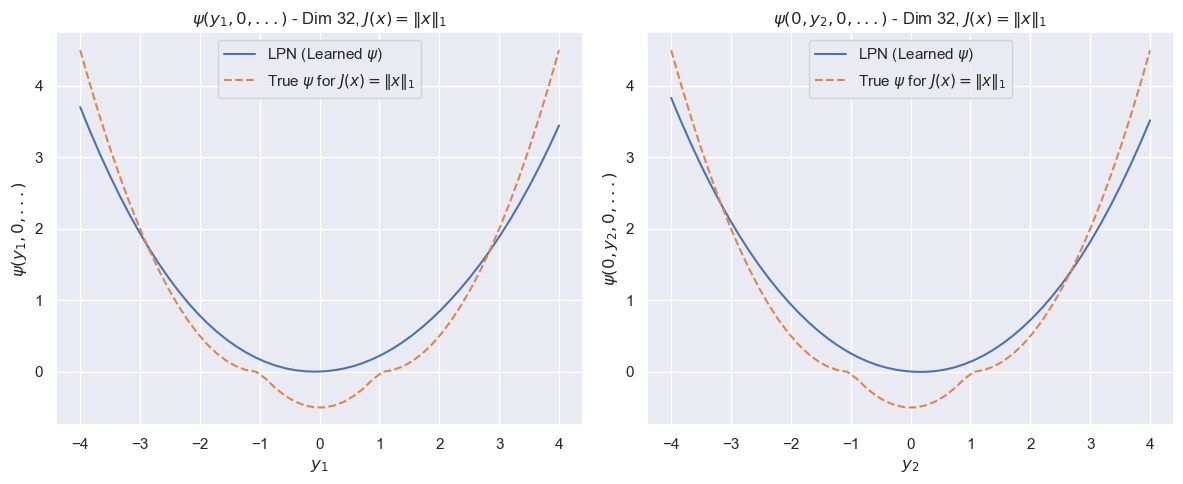

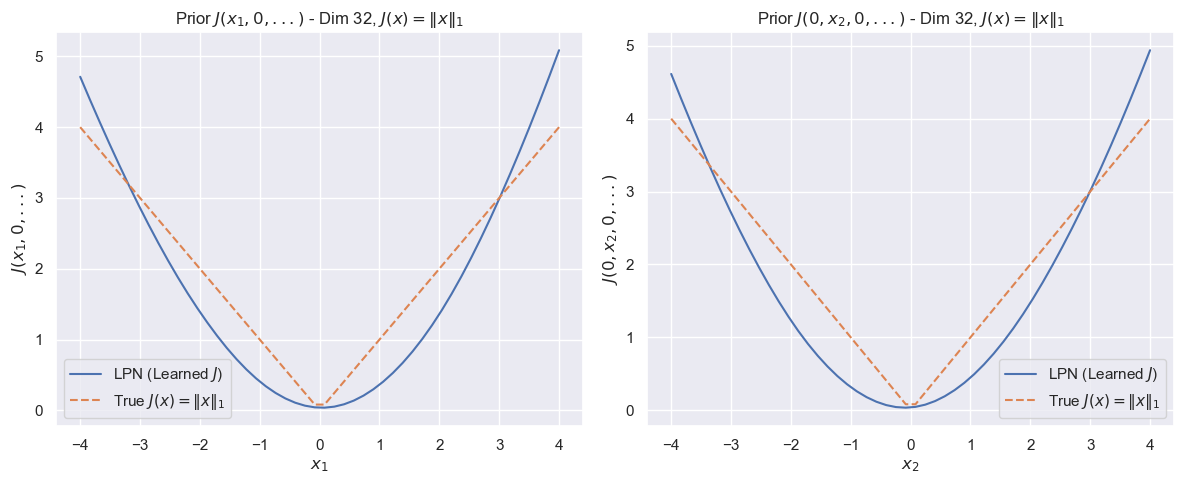

In [8]:
# L2 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

L1 loss -- Train

In [9]:

# print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
# lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=100, layers=layers, beta=beta,eps=0.5).to(device)
# optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-4)

# for i in range(iterations_exp_initial):
#      single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

# for g in optimizer_quad_l1.param_groups:
#     g["lr"] = 1e-4 
# for i in range(30000):
#     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

# torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

L1 loss -- Plot

In [10]:
# # L1 loss -- Plot
# plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)


Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [11]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [12]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [13]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [14]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [15]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [16]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)